In [1]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

c:\Users\Toshiba\anaconda3\envs\langgraphe2e\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
result = llm.invoke("Write a ballad about Sky")
print(result.content)

(Verse 1)
The Sky, a canvas vast and deep,
Where clouds like ships on oceans sleep,
A boundless blue, a fiery red,
A swirling grey above our head.
By day, a dome of dazzling light,
By night, a cloak of starry night.

(Verse 2)
The sun, a painter bold and bright,
With strokes of gold and amber light,
He paints the dawn, a rosy hue,
And sets the west in shades of blue.
The moon, a pearl of silver sheen,
Hangs in the dark, a silent queen.

(Verse 3)
The wind, a sculptor, swift and strong,
Shapes clouds to figures, righting wrong,
From fluffy sheep to towering peaks,
A fleeting beauty that he speaks.
He whispers secrets to the trees,
And rustles leaves upon the breeze.

(Verse 4)
The rain, a weeping, gentle hand,
That cleanses earth, across the land,
A silver curtain, soft and low,
That washes all the dust below.
Then rainbows arch, a vibrant sign,
A promise whispered, so divine.

(Verse 5)
The stars, like diamonds scattered wide,
Across the velvet, dark inside,
They twinkle bright, a cosm

In [4]:
#Create a retriever - RAG
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]


#Chunking
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
### Generate - RAG Chain

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(f"---Prompt---{prompt}")
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

---Prompt---input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [8]:
#Let's test the RAG Chain now
question = "What is an agent?"
generation = rag_chain.invoke({"context":docs,"question":question})
print(generation)

Based on the provided text, an agent is a system using a large language model (LLM) as its core controller.  It's complemented by key components like planning, memory (short-term and long-term), and tool use to solve complex problems autonomously.  Examples include AutoGPT, GPT-Engineer, and BabyAGI.


In [12]:
### Retrieval Grader or document grader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

c:\Users\Toshiba\anaconda3\envs\langgraphe2e\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [16]:
#testing the document
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [15]:
question = "Charlie Chaplin"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [17]:
#Query rewritter
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the different types of agent memory and how do they work?'

In [18]:
#Lets create a required function
#Retriever function
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.get_relevant_documents(question)
    
    return {"documents": documents, "question": question,}



In [19]:
#Grade document
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    
    
    filtered_docs = []

    web_search = "No"

    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        print(f"this is score {score}")

        grade = score.binary_score
        if grade == "yes":
            print("---GRADE : DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE : DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents":filtered_docs,"question":question,"web_search":web_search}
        

In [20]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        
    }

In [21]:
#Transform Query
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [22]:
# Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [23]:
#Web search
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [24]:
#Decide to generate - condition check
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [25]:
#RAG is working fine. Now let's implement the corrective RAG

from langgraph.graph import END, StateGraph, START

In [26]:
#Create a work flow
from typing import List

from typing_extensions import TypedDict


class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str] #Why we use all this inside the state? because i want to float all values through out the nodes, so we can define anything and its not the thumbrule to define.

workflow = StateGraph(State)

In [27]:
#Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

In [28]:
#Edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

In [29]:
#Compile the workflow
app = workflow.compile()

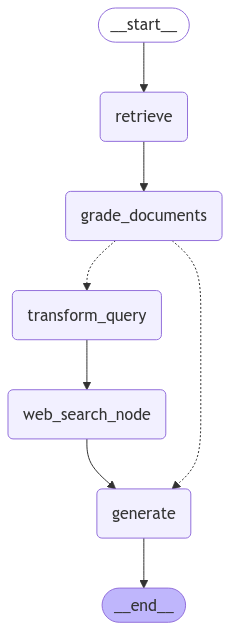

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}


In [32]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'


KeyError: "Input to ChatPromptTemplate is missing variables {'document'}.  Expected: ['document', 'question'] Received: ['question', 'documents']\nNote: if you intended {document} to be part of the string and not a variable, please escape it with double curly braces like: '{{document}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "